In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

from xgboost import XGBClassifier
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [9]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [11]:
train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

In [12]:
# 0 = Happy Customers , 1 = Unhappy Customers
df = pd.DataFrame(train.TARGET.value_counts())
df['Percentage'] = (df['TARGET']/df['TARGET'].sum())*100
# ~4% unhappy customers in dataset (unbalanced dataset)
df

,TARGET,Percentage
0,73012,96.043147
1,3008,3.956853


In [13]:
display(train.shape)
display(train.duplicated(train.columns[1:],keep=False).value_counts()[1])
# 5791 instances which contain duplicates (have every feature incl. target same)
display(train.duplicated(train.columns[1:],keep='first').value_counts()[1])
# out of the 5791 instances, 4807 are duplicate instances, so ulimately we keep 984 instances
# Now lets delete the duplicate instances as they dont add any value
train = train.drop(train[train.duplicated(train.columns[1:],keep='first')].index)
train.reset_index(drop=True,inplace=True)
# dropped 4807 duplicate instances
display(train.shape)

(76020, 371)

5791

4807

(71213, 371)

In [14]:
#Let see if the dataset have repeated instances with different class labels, which means noise.
noise_indices = train[train.duplicated(train.columns[1:-1],keep=False)&~train.duplicated(train.columns[1:],keep=False)].index
# print(noise_indices)
non_noise_indices = train.index.difference(noise_indices)
# print(non_noise_indices)
f'We have {len(noise_indices)} instances of noise, {len(non_noise_indices)} non_noise'
# display(train.iloc[noise_indices].head(1))
# display(train.iloc[non_noise_indices].head(1))

'We have 266 instances of noise, 70947 non_noise'

In [15]:
# Example of how i got the noise instances: ( Consider Age here as Target)
# df1 = pd.DataFrame({'Id':[1,2,3,4,5,6],'Name':['John','Peter','John','John','John','John'],'City':['Boston','Japan','Boston','Dallas','Dallas','Dallas'],'Age':[23,31,21,21,21,21]})
# display(df1)

# print('Result:')
# print('train without duplicates')
# df1.drop(df1[df1.duplicated(df1.columns[1:],keep='first')].index, axis=0, inplace=True);display(df1)

# noise_sample = df1[df1.duplicated(df1.columns[1:-1],keep=False)&~df1.duplicated(df1.columns[1:],keep=False)].index
# print('instances with multiple ages(noise)')
# display(df1.loc[noise_sample])
# df1.drop(index=[2],axis=0).reset_index(drop=True)

In [21]:
trainNTP = train.loc[non_noise_indices]
trainNTP = shuffle(trainNTP).reset_index(drop=True) #shuffling the training data
print(trainNTP.shape[0])
trainNTPsplit5 = int(trainNTP.shape[0]/5)
trainNTP1 = trainNTP[:trainNTPsplit5]
trainNTP2 = trainNTP[trainNTPsplit5:2*trainNTPsplit5]
trainNTP3 = trainNTP[2*trainNTPsplit5:3*trainNTPsplit5]
trainNTP4 = trainNTP[3*trainNTPsplit5:4*trainNTPsplit5]
trainNTP5 = trainNTP[4*trainNTPsplit5:]
print(trainNTP1.shape[0], trainNTP2.shape[0], trainNTP3.shape[0], trainNTP4.shape[0], trainNTP5.shape[0])

70947
14189 14189 14189 14189 14191


In [23]:
# # train_for_noise_target_pred
# trainNTP = train.loc[non_noise_indices]
# trainNTP = shuffle(trainNTP).reset_index(drop=True) #shuffling the training data
# print("trainNTP",trainNTP.shape[0])

# trainNTP_0 = trainNTP[trainNTP.TARGET == 0]
# trainNTP_1 = trainNTP[trainNTP.TARGET == 1]

# trainNTP_0split5 = int(trainNTP_0.shape[0]/5)

# trainNTP1 = trainNTP_0[:trainNTP_0split5]
# trainNTP1 = pd.concat([trainNTP1,trainNTP_1])

# trainNTP2 = trainNTP_0[trainNTP_0split5:2*trainNTP_0split5]
# trainNTP2 = pd.concat([trainNTP2,trainNTP_1])

# trainNTP3 = trainNTP_0[2*trainNTP_0split5:3*trainNTP_0split5]
# trainNTP3 = pd.concat([trainNTP3,trainNTP_1])

# trainNTP4 = trainNTP_0[3*trainNTP_0split5:4*trainNTP_0split5]
# trainNTP4 = pd.concat([trainNTP4,trainNTP_1])

# trainNTP5 = trainNTP_0[4*trainNTP_0split5:]
# trainNTP5 = pd.concat([trainNTP5,trainNTP_1])

# print(trainNTP1.shape[0], trainNTP2.shape[0], trainNTP3.shape[0], trainNTP4.shape[0], trainNTP5.shape[0])
# print(trainNTP1.shape[0]+trainNTP2.shape[0]+trainNTP3.shape[0]+trainNTP4.shape[0]+trainNTP5.shape[0])

In [26]:
trainNTP1_y = trainNTP1.TARGET
trainNTP1_X = trainNTP1.drop(['ID','TARGET'],axis=1)
trainNTP1_xgb = XGBClassifier(n_estimators=100, max_depth=10, n_jobs=-1, seed=42)
trainNTP1_xgb.fit(trainNTP1_X, trainNTP1_y)

trainNTP2_y = trainNTP2.TARGET
trainNTP2_X = trainNTP2.drop(['ID','TARGET'],axis=1)
trainNTP2_xgb = XGBClassifier(n_estimators=100, max_depth=10, n_jobs=-1, seed=42)
trainNTP2_xgb.fit(trainNTP2_X, trainNTP2_y)

trainNTP3_y = trainNTP3.TARGET
trainNTP3_X = trainNTP3.drop(['ID','TARGET'],axis=1)
trainNTP3_xgb = XGBClassifier(n_estimators=100, max_depth=10, n_jobs=-1, seed=42)
trainNTP3_xgb.fit(trainNTP3_X, trainNTP3_y)

trainNTP4_y = trainNTP4.TARGET
trainNTP4_X = trainNTP4.drop(['ID','TARGET'],axis=1)
trainNTP4_xgb = XGBClassifier(n_estimators=100, max_depth=10, n_jobs=-1, seed=42)
trainNTP4_xgb.fit(trainNTP4_X, trainNTP4_y)

trainNTP5_y = trainNTP5.TARGET
trainNTP5_X = trainNTP5.drop(['ID','TARGET'],axis=1)
trainNTP5_xgb = XGBClassifier(n_estimators=100, max_depth=10, n_jobs=-1, seed=42)
trainNTP5_xgb.fit(trainNTP5_X, trainNTP5_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1)

In [27]:
noise = train.iloc[noise_indices]
print('noise:',noise.shape)

noise: (266, 371)


In [28]:
noise_y = noise.TARGET
noise_X = noise.drop(['ID','TARGET'],axis=1)
pred1 = trainNTP1_xgb.predict(noise_X)
display(pred1)
pred2 = trainNTP2_xgb.predict(noise_X)
# display(pred2)
pred3 = trainNTP3_xgb.predict(noise_X)
# display(pred3)
pred4 = trainNTP3_xgb.predict(noise_X)
# display(pred4)
pred5 = trainNTP3_xgb.predict(noise_X)
# display(pred5)
pd.DataFrame({'pred1':pred1})

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

,pred1
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [29]:
# remove constant columns (std = 0)
remove = []
for col in train.columns:
    if(train[col].std()==0):
        remove.append(col)
print(remove)
print(len(remove))
train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)
train.shape
# we thereby removed 34 columns which dont add any relevancy (trying to minimize the curse of dimentionality)
# 371 features => 337 features

['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']
34


(71213, 337)

In [30]:
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1, len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])
print(remove)
print(len(remove))
train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)
train.shape
# we thereby removed 29 columns which are duplicates (trying to minimize the curse of dimentionality)
# 337 features => 308 features

['ind_var29_0', 'ind_var29', 'ind_var13_medio', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var32', 'ind_var34', 'ind_var37', 'ind_var39', 'num_var29_0', 'num_var29', 'num_var13_medio', 'num_var18', 'num_var26', 'num_var25', 'num_var32', 'num_var34', 'num_var37', 'num_var39', 'saldo_var29', 'saldo_medio_var13_medio_ult1', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_reemb_var33_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3']
29


(71213, 308)

In [31]:
test_ids = test.ID
test.drop(['ID'], axis=1, inplace=True)

X = train.drop(['ID','TARGET'], axis=1)
y = train.TARGET

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape, test.shape)

(56970, 306) (14243, 306) (75818, 306)


In [33]:
etc = ExtraTreesClassifier(random_state=42)
selector = etc.fit(X_train,y_train)

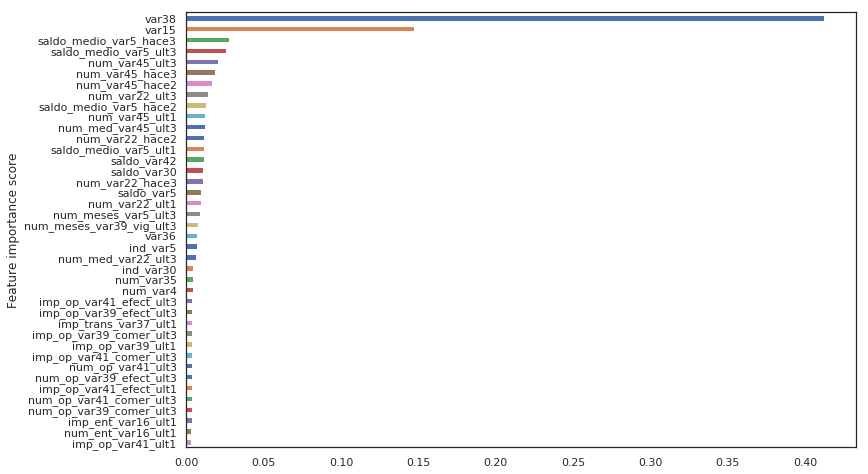

In [34]:
feat_imp = pd.Series(etc.feature_importances_,index=X_train.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='barh',figsize=(12,8)).invert_yaxis()
plt.ylabel('Feature importance score');
# var38 is most important feature (a little too much)

In [35]:
# feat_imp.shape = (306,)
fs = SelectFromModel(selector, prefit=True) # Meta-transformer for selecting features based on importance weights.
#selector is trained ETC classifier model
#prefit -> Whether a prefit model is expected to be passed into the constructor directly or not.
#If True, transform must be called directly
X_train = fs.transform(X_train) # Reduce X to the selected features
X_test = fs.transform(X_test)
test = fs.transform(test)
print(X_train.shape, X_test.shape, test.shape)
# Before: (60816, 306) (15204, 306) (75818, 306)

(56970, 43) (14243, 43) (75818, 43)


In [36]:
#train model
m_xgb = XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1, seed=42)
m_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='auc')
# eval_set -> A list of (X, y) tuple pairs to use as a validation set
# eval_metrix -> If a str, should be a built-in evaluation metric to use. using Area Under ROC Curve. 

[0]	validation_0-auc:0.800962
[1]	validation_0-auc:0.804064
[2]	validation_0-auc:0.810971
[3]	validation_0-auc:0.817975
[4]	validation_0-auc:0.817488
[5]	validation_0-auc:0.81913
[6]	validation_0-auc:0.82021
[7]	validation_0-auc:0.820073
[8]	validation_0-auc:0.819775
[9]	validation_0-auc:0.822096
[10]	validation_0-auc:0.82225
[11]	validation_0-auc:0.82183
[12]	validation_0-auc:0.821715
[13]	validation_0-auc:0.822385
[14]	validation_0-auc:0.821572
[15]	validation_0-auc:0.821204
[16]	validation_0-auc:0.822012
[17]	validation_0-auc:0.823845
[18]	validation_0-auc:0.823322
[19]	validation_0-auc:0.82901
[20]	validation_0-auc:0.830572
[21]	validation_0-auc:0.830758
[22]	validation_0-auc:0.830313
[23]	validation_0-auc:0.830573
[24]	validation_0-auc:0.831308
[25]	validation_0-auc:0.830117
[26]	validation_0-auc:0.830754
[27]	validation_0-auc:0.831545
[28]	validation_0-auc:0.831185
[29]	validation_0-auc:0.831089
[30]	validation_0-auc:0.830957
[31]	validation_0-auc:0.831548
[32]	validation_0-auc:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=1)

In [37]:
m_xgb.predict_proba(X_test)
#  predict_proba: Predict the probability of each data example being of a given class.


array([[0.9918459 , 0.0081541 ],
       [0.7535105 , 0.24648954],
       [0.9947226 , 0.00527743],
       ...,
       [0.9881653 , 0.0118347 ],
       [0.9672586 , 0.03274146],
       [0.9721895 , 0.0278105 ]], dtype=float32)

In [38]:
#Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
print('ROC AUC score', roc_auc_score(y_true=y_test, y_score=m_xgb.predict_proba(X_test)[:,1], average='macro'))
# y_true -> True binary labels
# y_scores -> Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions
# average -> this determines the type of averaging performed on the data:
# 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

ROC AUC score 0.8447098016050023


<table>
 <tr>
     <th>Comment</th>
     <th>ROC AUC Score</th>
 </tr>
    <tr>
     <td>Initial</td>
     <td>**0.8407427605523421**</td>
 </tr>
    <tr>
     <td>Dropping Duplicate Rows</td>
     <td>**0.8444199180132365**</td>
 </tr>
</table>



In [ ]:
submission = pd.DataFrame({'ID':test_ids,'TARGET': m_xgb.predict_proba(test)[:,1]})
submission.to_csv('submission.csv',index=False)

<table>
 <tr>
     <th>Comment</th>
     <th>Public Score</th>
     <th>Private Score</th>
 </tr>
    <tr>
     <td>Initial</td>
     <td>**0.83460**</td>
     <td>**0.82096**</td>
 </tr>
    <tr>
     <td>Dropping Duplicate Rows</td>
     <td>**0.83525**</td>
     <td>**0.82099**</td>
 </tr>
</table>
Public score is computed based on 50% of test data, where as private score is computed on the whole test data

 Q. Isn't the output supposed to be in zero and ones <br>
 A.Nope, the output should be the probability of measuring that class. Then the output is evaluated from the area under the 'receiving operating characteristic' curve.
 
 Q.What is LB score in kaggle? <br>
 A.In the context of Kaggle, it means LeaderBoard (emphasis mine).
